In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import math

import torch.optim as optim
import numpy as np
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 


from data_sets.generate_data_sets import TestFunctions
from trainig.training import Trainer

from mmnn import G_MMNN,SinTu
from base_lines.base_lines import MCDropoutNN


from uq_methods.UQ import NN_UQ

# plt.style.use('figures/images_style.mplstyle')

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [3]:
f1 = TestFunctions.f1_MMNN

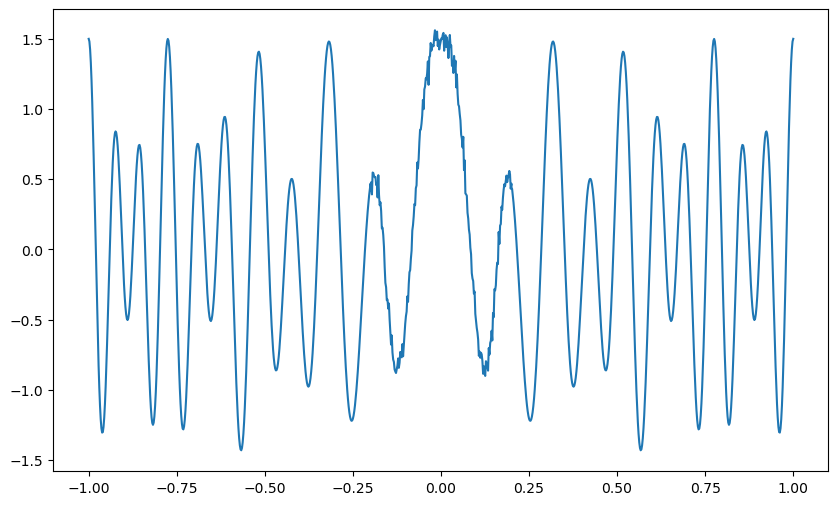

In [4]:
torch.manual_seed(0)
x_train_no_noise = torch.cat([
    torch.linspace(-1, -0.2, 400),
    torch.linspace(0.2, 1, 400)
]).to(device)
y_train_no_noise = f1(x_train_no_noise) 


x_train_noise = torch.linspace(-.2,.2, 200).to(device)
y_train_noise = f1(x_train_noise) + 0.05 * torch.randn_like(x_train_noise)    

x_train = torch.cat([x_train_no_noise, x_train_noise], dim=0).to(device)
x_argsort = torch.argsort(x_train, dim=0)
x_train = x_train[x_argsort].unsqueeze(1)
y_train = torch.cat([y_train_no_noise, y_train_noise], dim=0).to(device)
y_train = y_train[x_argsort].unsqueeze(1)
plt.figure(figsize=(10,6))
plt.plot(x_train.cpu(), y_train.cpu(), label='Train')
plt.show()

x_val = torch.linspace(-1., 1., 500).to(device).unsqueeze(1)
y_val = f1(x_val) + 0.0 * torch.randn_like(x_val)



# Setup model

In [5]:
model = G_MMNN(
    ranks = [1]+[36]*5+[1],
    widths = [366]*6,
    device  = device,
    n_gaussian_layers=1,
    sigma=0.25,
    fixWb=True
)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)


MMNN_UQ Configuration:
  Total W,b layers: 6
  Gaussian W,b layers: 1
  Gaussian layer indices: [5]
  Creating Gaussian sampler for layer 5 (fcs[10])
  Total samplers created: 1


In [6]:
trainer = Trainer(model = model, device=device, optimizer=optimizer, scheduler=scheduler)

In [7]:
loss,loss_epoch = trainer.train(
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    epochs=1000,
    batch_size = 250,
    verbose=True,
    validation_freq=150,
    save_dir=None,
    saving_interval=None)
    

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s, Batch Loss=0.608]/work/Sebas/MMNN/uq_methods/metrics.py:71: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  quantiles = torch.quantile(pred_samples, alphas, dim=0)  # (99, D)
/work/Sebas/MMNN/uq_methods/metrics.py:109: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  lower_quantile = torch.quantile(pred_samples, alpha / 2, dim=0)  # (D,)
/work/

Epoch [1/1000], Training Loss: 0.696555, validation metrics: {'l2_loss': 0.8097927570343018, 'crps': 0.3068675696849823, 'nll': 2.2297096252441406, 'es': 0.6185299754142761, 'coverage': 0.15200001001358032, 'pred_interval': 0.4455406665802002}


Training Progress:  15%|█▌        | 153/1000 [00:07<01:29,  9.51it/s, Batch Loss=0.109]  

Epoch [151/1000], Training Loss: 0.133874, validation metrics: {'l2_loss': 0.15883328020572662, 'crps': 0.04608514532446861, 'nll': 0.15282844007015228, 'es': 0.09044166654348373, 'coverage': 0.9240000247955322, 'pred_interval': 0.6448137760162354}


Training Progress:  30%|███       | 305/1000 [00:14<00:50, 13.71it/s, Batch Loss=0.0296] 

Epoch [301/1000], Training Loss: 0.046460, validation metrics: {'l2_loss': 0.08762145042419434, 'crps': 0.027374640107154846, 'nll': -0.05445554479956627, 'es': 0.05370534956455231, 'coverage': 0.9500000476837158, 'pred_interval': 0.4313259720802307}


Training Progress:  45%|████▌     | 453/1000 [00:20<00:53, 10.22it/s, Batch Loss=0.0638] 

Epoch [451/1000], Training Loss: 0.035412, validation metrics: {'l2_loss': 0.12415811419487, 'crps': 0.037262797355651855, 'nll': 0.08066751062870026, 'es': 0.07308828085660934, 'coverage': 0.9860000610351562, 'pred_interval': 0.558456301689148}


Training Progress:  61%|██████    | 606/1000 [00:27<00:39,  9.92it/s, Batch Loss=0.0364] 

Epoch [601/1000], Training Loss: 0.040752, validation metrics: {'l2_loss': 0.09810913354158401, 'crps': 0.03011232428252697, 'nll': -0.032962262630462646, 'es': 0.05907811224460602, 'coverage': 0.9580000638961792, 'pred_interval': 0.46052980422973633}


Training Progress:  76%|███████▌  | 756/1000 [00:33<00:15, 15.37it/s, Batch Loss=0.0203] 

Epoch [751/1000], Training Loss: 0.012679, validation metrics: {'l2_loss': 0.10026542097330093, 'crps': 0.032614946365356445, 'nll': -0.021877538412809372, 'es': 0.06398440152406693, 'coverage': 0.9960000514984131, 'pred_interval': 0.46974989771842957}


Training Progress:  91%|█████████ | 906/1000 [00:40<00:07, 12.17it/s, Batch Loss=0.00707]

Epoch [901/1000], Training Loss: 0.050725, validation metrics: {'l2_loss': 0.10991261154413223, 'crps': 0.03236522898077965, 'nll': -0.02808995731174946, 'es': 0.06350450217723846, 'coverage': 0.89000004529953, 'pred_interval': 0.42150697112083435}


Training Progress: 100%|██████████| 1000/1000 [00:45<00:00, 22.17it/s, Batch Loss=0.0231]

Epoch [1000/1000], Training Loss: 0.024360, validation metrics: {'l2_loss': 0.0463687926530838, 'crps': 0.020142681896686554, 'nll': 0.0021932406816631556, 'es': 0.039500582963228226, 'coverage': 1.0, 'pred_interval': 0.512346088886261}
